# Analyzing download speeds in Kentucky counties using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to Kentucky counties
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [131]:
import geopandas as gp
from IPython.display import HTML, display
import tabulate
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Download data

First, download the data using the link below

In [4]:
tile_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2020/quarter%3D2/2020-04-01_performance_fixed_tiles.zip"
tiles = gp.read_file(tile_url)

In [77]:
# print(tiles.head())

geopandas.geodataframe.GeoDataFrame

## Get county boundaries

Then, I’ll load the Kentucky county boundaries from the U.S. Census Bureau ftp site.

In [5]:
county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" # zipfile of U.S. county boundaries
counties = gp.read_file(county_url)
ky_counties = counties.loc[counties['STATEFP'] == '21'].to_crs(4326) # filter out the Kentucky fips code and reproject to match the tiles

In [78]:
print(ky_counties.head())

    STATEFP COUNTYFP  COUNTYNS  GEOID      NAME         NAMELSAD LSAD CLASSFP  \
9        21      053  00516873  21053   Clinton   Clinton County   06      H1   
58       21      003  00516848  21003     Allen     Allen County   06      H1   
66       21      231  00516962  21231     Wayne     Wayne County   06      H1   
133      21      209  00516951  21209     Scott     Scott County   06      H1   
157      21      061  00516877  21061  Edmonson  Edmonson County   06      H1   

     MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
9    G4020  None   None     None        A   510875755  21152699  +36.7272577   
58   G4020   150  14540     None        A   891838779  19482100  +36.7507703   
66   G4020  None   None     None        A  1186690748  67283816  +36.8007715   
133  G4020   336  30460     None        A   729774435   9440820  +38.2857099   
157  G4020   150  14540     None        A   784468358  13258105  +37.2275136   

         INTPTLON               

geopandas.geodataframe.GeoDataFrame

## Join tiles to counties

Now I’ll join the tiles to the counties. I use left = FALSE because I only want to include counties that have at least 1 tile.

In [7]:
tiles_in_ky_counties = gp.sjoin(tiles, ky_counties, how="inner", op='intersects')

In [26]:
# convert to Mbps for easier reading
tiles_in_ky_counties['avg_d_mbps'] = tiles_in_ky_counties['avg_d_kbps'] / 1000
tiles_in_ky_counties['avg_u_mbps'] = tiles_in_ky_counties['avg_u_kbps'] / 1000

In [27]:
# print(tiles_in_ky_counties.head())

               quadkey  avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  devices  \
370   0320003031132232      236452       55959          40     37       11   
1653  0320003121002010      128046       59741          42     76       13   
2825  0320003102323032      228717       68654          38     18       10   
8662  0320003120131011        6940         999         458      8        2   
9703  0320003031131230      154782       59655          35     23        8   

                                               geometry  index_right STATEFP  \
370   POLYGON ((-85.85815 38.13888, -85.85266 38.138...         2534      21   
1653  POLYGON ((-85.41870 38.23818, -85.41321 38.238...         2534      21   
2825  POLYGON ((-85.55054 38.29425, -85.54504 38.294...         2534      21   
8662  POLYGON ((-85.45715 38.20366, -85.45166 38.203...         2534      21   
9703  POLYGON ((-85.81421 38.17775, -85.80872 38.177...         2534      21   

     COUNTYFP  ... CSAFP CBSAFP METDIVFP FUNCSTAT 

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [163]:
def wm(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
    
county_stats = tiles_in_ky_counties.groupby(['GEOID', 'NAMELSAD']) \
       .apply(lambda x: pd.Series({'avg_d_mbps_wt': np.average(x['avg_d_mbps'], weights=x['tests'])})) \
       .reset_index() \
       .merge(tiles_in_ky_counties.groupby(['GEOID', 'NAMELSAD']).agg(tests = ("GEOID", "size")).reset_index(), on = ['GEOID', 'NAMELSAD'])

In [165]:
table_stats = county_stats.loc[county_stats['tests'] >= 50].nlargest(20, 'avg_d_mbps_wt') \
    .append(county_stats.loc[county_stats['tests'] >= 50].nsmallest(20, 'avg_d_mbps_wt')) \
    .sort_values('avg_d_mbps_wt', ascending = False)

display(HTML(tabulate.tabulate(table_stats, tablefmt='html', headers=["GEOID", "County", "Avg download speed (Mbps)", "Tests"])))

,GEOID,County,Avg download speed (Mbps),Tests
55,21111,Jefferson County,159.023,2938
33,21067,Fayette County,154.133,1170
104,21209,Scott County,151.205,441
79,21159,Martin County,150.304,208
23,21047,Christian County,146.726,486
92,21185,Oldham County,144.915,680
38,21077,Gallatin County,144.212,86
75,21151,Madison County,144.167,666
24,21049,Clark County,144.069,206
6,21013,Bell County,143.686,232


## Map the counties

The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

In [130]:
county_data = ky_counties[['GEOID', 'geometry']].merge(county_stats, on='GEOID')

labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(county_data.avg_d_mbps, (0, 25, 50, 100, 150, 200), right=False, labels = labels)

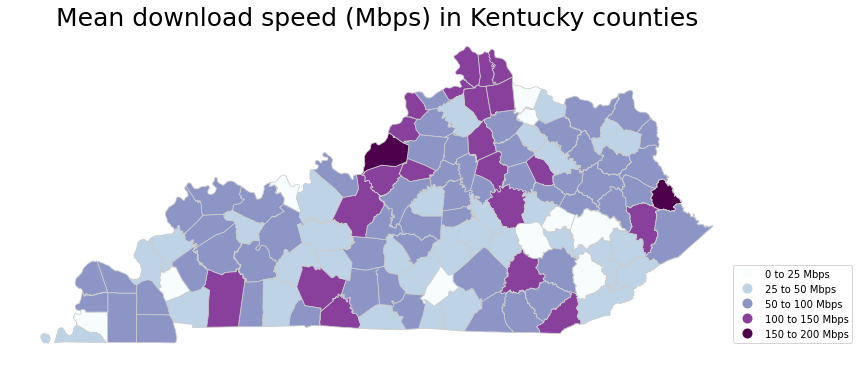

In [129]:
fig, ax = pyplt.subplots(1, figsize=(16, 6))

county_data.plot(column='group', cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.axis('off')

# add a title

ax.set_title('Mean download speed (Mbps) in Kentucky counties', fontdict={'fontsize': '25', 'fontweight' : '3'})

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,0.3))

